In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from d2l import torch as d2l
import matplotlib.pyplot as plt
from IPython import display
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
torch.__version__

'2.4.1'

In [12]:
# 1. 准备数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [19]:
# 输入的数据维度为 256*1*28*28
# 输出维度为 256*1, 这一个维度问题在后面的损失函数的说
for X, y in train_iter:
    print(X.shape)
    print(y.shape)
    print(y)
    break

torch.Size([256, 1, 28, 28])
torch.Size([256])
tensor([5, 5, 0, 4, 7, 6, 7, 5, 1, 7, 6, 4, 9, 0, 6, 9, 6, 0, 4, 0, 0, 7, 2, 3,
        4, 8, 3, 0, 7, 9, 9, 7, 4, 0, 0, 7, 3, 8, 9, 1, 4, 0, 5, 9, 1, 4, 6, 7,
        4, 8, 3, 0, 9, 2, 4, 9, 1, 5, 5, 5, 4, 1, 1, 7, 2, 9, 8, 7, 0, 8, 6, 8,
        5, 8, 0, 7, 0, 2, 3, 6, 8, 8, 7, 9, 3, 1, 8, 2, 4, 6, 3, 2, 6, 2, 2, 8,
        9, 7, 0, 7, 4, 9, 5, 6, 4, 2, 2, 0, 0, 2, 3, 8, 1, 7, 6, 9, 2, 5, 9, 6,
        5, 0, 4, 0, 0, 5, 0, 7, 3, 9, 6, 7, 8, 8, 0, 8, 0, 0, 4, 0, 4, 7, 9, 0,
        3, 3, 0, 8, 6, 9, 7, 4, 7, 2, 4, 2, 1, 2, 0, 4, 4, 3, 7, 9, 1, 0, 6, 5,
        0, 7, 1, 4, 3, 9, 8, 6, 0, 6, 5, 3, 4, 3, 7, 4, 3, 8, 8, 1, 8, 9, 2, 3,
        4, 7, 9, 7, 9, 9, 5, 5, 6, 4, 3, 6, 2, 0, 2, 3, 8, 7, 5, 2, 7, 6, 7, 2,
        9, 3, 9, 6, 2, 6, 7, 6, 5, 8, 9, 4, 9, 4, 9, 6, 1, 6, 3, 5, 7, 4, 5, 1,
        6, 8, 3, 9, 7, 7, 3, 5, 8, 6, 2, 0, 4, 9, 3, 2])


In [20]:
# 2. 定义网络并且初始化参数
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights) # apply 函数表示应用任何函数在模型上

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [23]:
# 3. 定义损失函数, 关于这一个损失函数在后面总结的位置说明一下
loss = nn.CrossEntropyLoss(reduction='none')

In [25]:
# 4. 定义优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

In [35]:
# 注意 accuracy 的写法
x = torch.normal(0, 1, (3, 10))
x.argmax(axis=1)

tensor([3, 2, 7])

In [36]:
# 各种工具函数
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())
# 累加值
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)
    # 类似于 operator[] 可以返回对应索引位置的元素
    def __getitem__(self, idx):
        return self.data[idx]
# 评估准确率
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    metric = Accumulator(2)  # 正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel()) # 后者表示元素总数
    return metric[0] / metric[1]
# 评估初始权重
evaluate_accuracy(net, test_iter)

def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

# 一个关于绘制的函数
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

# 训练模型
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

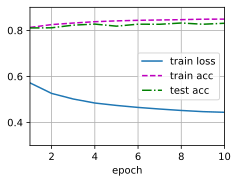

In [31]:
# 5. 模型训练
# 每一个 epoch 训练完之后可`以在整个测试集上进行测试, 从而测试分类模型的准确率
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# 补充

## softmax改进
对于 softmax 函数: $\hat{y}_j = \frac{\exp{o_j}}{\sum_k \exp{o_k}}$, 如果 $o_k$ 过大可能导致结果溢出, 最终可能得到 0, inf, nan等, 此时无法得到一个明确的交叉熵值, 所以很自然可以想到可以约束一下 $o_k$, 此时只需要把 $o_k$ 换成 $o_k - max(o_k)$即可, 那么此时改进之后的 softmax 函数如下:
$$
\hat{y}_j = \frac{\exp(o_j - \max(o_k)) \exp(\max(o_k))}{\sum_k \exp(o_k - \max(o_k)) \exp(\max(o_k))} \\
= \frac{\exp(o_j - \max(o_k))}{\sum_k \exp(o_k - \max(o_k))}.
$$
但是此时依然存在问题, 如果 $o_k - max(o_k)$ 是一个非常小的负数的时候, 可能导致 $\exp {o_k - max{o_k}}$ 非常接近 0, 所以此时不应该单独计算 softmax, 既然我们需要计算对数, 那么可以把 softmax 和交叉熵放在一起计算, 那么此时可以得到:
$$
\begin{align*}
\log(\hat{y}_j) &= \log\left( \frac{\exp(o_j - \max(o_k))}{\sum_k \exp(o_k - \max(o_k))} \right) \\
&= \log\left( \exp(o_j - \max(o_k)) \right) - \log\left( \sum_k \exp(o_k - \max(o_k)) \right) \\
&= o_j - \max(o_k) - \log\left( \sum_k \exp(o_k - \max(o_k)) \right).
\end{align*}
$$
此时由于只需要比较大小(使用 one-hot 向量编码), 所以此时可以省略最后的常数项, 只需要计算 $o_j - max(o_k)$ 即可

## 损失函数说明
这里使用损失函数 `nn.CrossEntroyLoss`, 我们这里还是使用一个线性神经网络, 只是损失函数需要对于输出进行处理而以, 所以网络中比一定需要出现 softmax 函数, 注意 `reduction`的三个选项不同的含义:
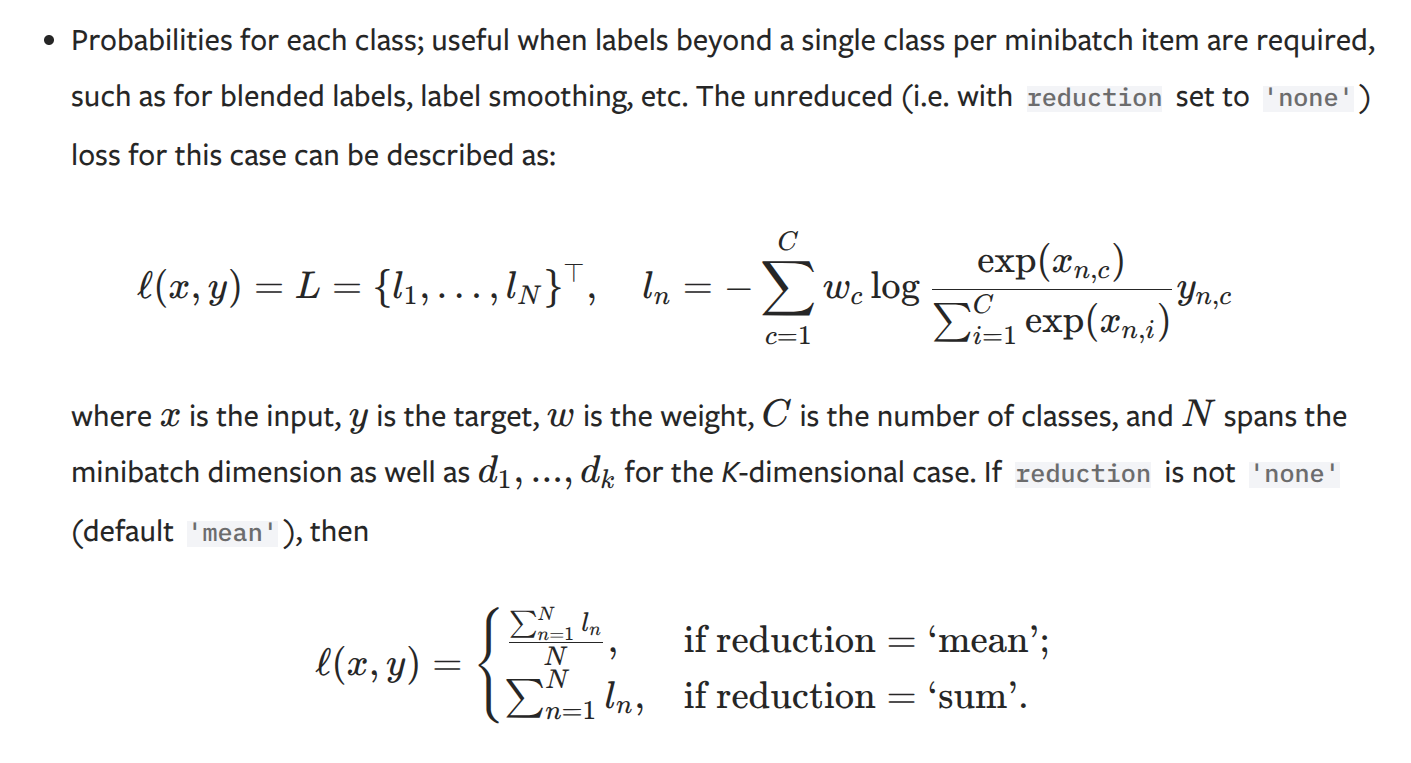
这里由于使用了 `one-hot` 编码, 其实交叉熵就是 $-\log(\hat{y}_j)$
参考: https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

## nn.Flatten
`nn.Flatten` 的作用是把输入进行展开, 展开一维向量从而输入到全连接层中, 比如一个图片的输入为 `[batch_size, channels, height, width]` 的四维向量, 但是全连接层需要输入 `[batch_size, features]` 的数据, 所以使用 `nn.Flatten` 把输入变换为 `[batch_size, channels*height*width]` 的向量

## 思考
1. 对于一个模型, 注意输入的数据(特别是输入图片或者序列的情况下), 同时需要注意输出的形状
2. `softmax`也是一种线性模型, 和线性回归的不同之处在于最后使用的损失函数不同, 线性回归模型使用平方损失函数, 这里使用交叉熵损失函数来进行分类, 同时参数指标不同, 还有准确率等指标(输入相同, 但是一个损失函数中使用了 `softmax` 函数)
3. 区分测试集和训练集, 一个 `epoch` 中会过一遍训练集, 同时如果硬件支持也可以在测试集中过一遍准确率
4. 注意训练过程中收集数据并且画图等操作
5. 注意利用 `torchvision` 进行图像数据集的加载和图像数据集的变换